Using the Northwind database, an open-source dataset created by Microsoft, this Jupyter notebook will do some exploratory data analysis and use hypothesis testing to dive deep into four questions:
1. Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?
2. Do discounts have a statistically significant effect on the dollar value of orders?
3. Do older customers have statistically significant larger value orders?
4. 


Step 1: Import the libraries used.

In [1]:
#imports
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
%matplotlib inline

from math import sqrt
import scipy.stats as stats
from sklearn import preprocessing

from datetime import datetime

Step 1: Create an sqalchemy "engine" to query the database tables.

In [2]:
# create the SQL engine
# optinal - to use the large version of the databse, use this to create the SQL engine:
# engine = create_engine('sqlite:///Northwind_large.sqlite', echo=True)

# using the small version of the databse:
engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)
con = engine.connect()
Session = sessionmaker(bind=engine)
session = Session()

2019-05-11 08:15:20,079 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-05-11 08:15:20,081 INFO sqlalchemy.engine.base.Engine ()
2019-05-11 08:15:20,083 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-05-11 08:15:20,085 INFO sqlalchemy.engine.base.Engine ()


In [3]:
# have a look at the various tables
inspector = inspect(engine)
print(inspector.get_table_names())

2019-05-11 08:15:20,093 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-05-11 08:15:20,095 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


There are 13 tables. This chart shows the relationships between the tables.
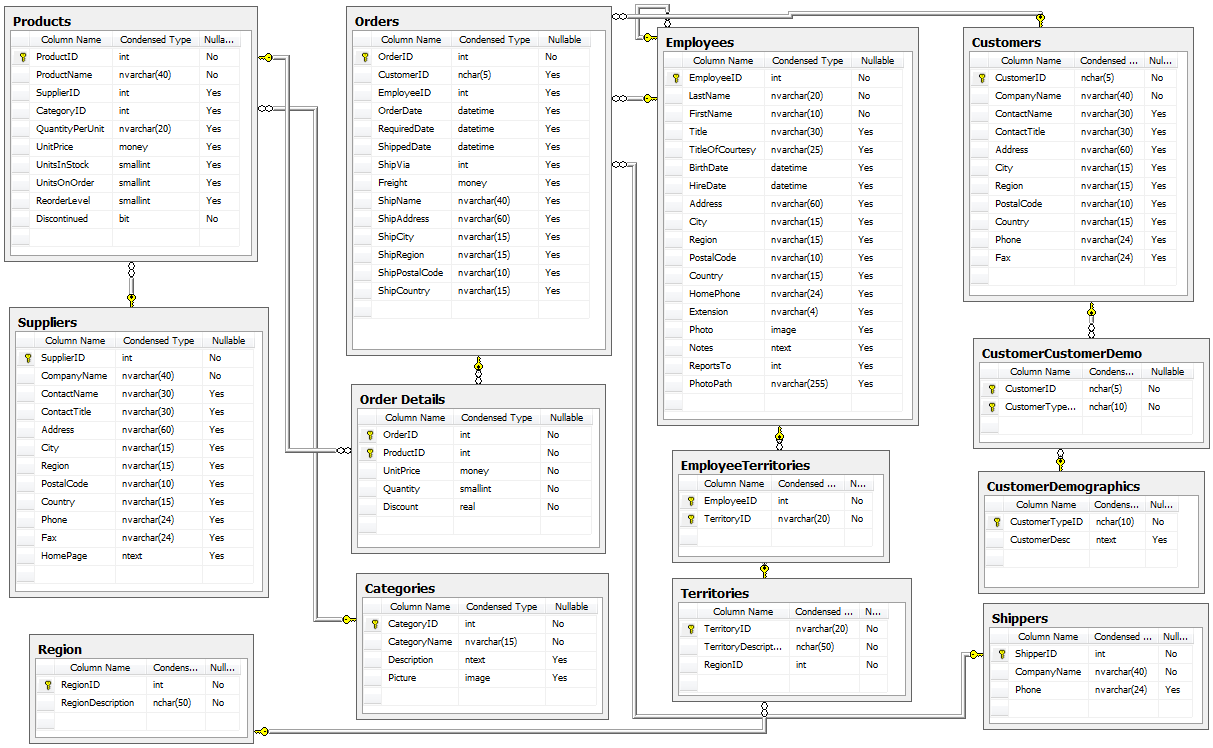

As I will be creating multiple pandas dataframes from the sql tables, I need a function that will return the column names from an SQL table.

In [4]:
def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    
    print("Table Name: {}".format(col_name))
    print("")
    
    for column in cols_list:
        print("Name: {} \t Type: {}".format(column['name'], column['type']))

In [5]:
#function to return a list of the column names from table given as an argument
def make_column_list(table):
    cols = []  #make an empty list
    cols_dict = inspector.get_columns(table)  # make a dict of the column names from the SQL table
#     print(cols_list)
    for column in cols_dict:
        cols.append(column['name'])
#     print(cols)
    return cols

In [6]:
# crate a pandas dataframe of the OrderDetail table
rs = con.execute('SELECT * FROM OrderDetail')
order_detail = pd.DataFrame(rs.fetchall())

column_names = make_column_list('OrderDetail')
order_detail.columns = column_names

order_detail.head()

2019-05-11 08:15:20,124 INFO sqlalchemy.engine.base.Engine SELECT * FROM OrderDetail
2019-05-11 08:15:20,127 INFO sqlalchemy.engine.base.Engine ()
2019-05-11 08:15:20,146 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("OrderDetail")
2019-05-11 08:15:20,148 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [7]:
# customer table to a pandas dataframe
rs = con.execute('SELECT * FROM Customer')
customers = pd.DataFrame(rs.fetchall())
column_names = make_column_list('Customer')
customers.columns = column_names

customers.head(10)

2019-05-11 08:15:20,181 INFO sqlalchemy.engine.base.Engine SELECT * FROM Customer
2019-05-11 08:15:20,184 INFO sqlalchemy.engine.base.Engine ()
2019-05-11 08:15:20,190 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Customer")
2019-05-11 08:15:20,193 INFO sqlalchemy.engine.base.Engine ()


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67
5,BLAUS,Blauer See Delikatessen,Hanna Moos,Sales Representative,Forsterstr. 57,Mannheim,Western Europe,68306,Germany,0621-08460,0621-08924
6,BLONP,Blondesddsl père et fils,Frédérique Citeaux,Marketing Manager,"24, place Kléber",Strasbourg,Western Europe,67000,France,88.60.15.31,88.60.15.32
7,BOLID,Bólido Comidas preparadas,Martín Sommer,Owner,"C/ Araquil, 67",Madrid,Southern Europe,28023,Spain,(91) 555 22 82,(91) 555 91 99
8,BONAP,Bon app,Laurence Lebihan,Owner,"12, rue des Bouchers",Marseille,Western Europe,13008,France,91.24.45.40,91.24.45.41
9,BOTTM,Bottom-Dollar Markets,Elizabeth Lincoln,Accounting Manager,23 Tsawassen Blvd.,Tsawassen,North America,T2F 8M4,Canada,(604) 555-4729,(604) 555-3745


In [8]:
# get full orders
rs = con.execute('SELECT * FROM [Order]')
orders = pd.DataFrame(rs.fetchall())

column_names = make_column_list('Order')
orders.columns = column_names

orders.head()

2019-05-11 08:15:20,219 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Order]
2019-05-11 08:15:20,222 INFO sqlalchemy.engine.base.Engine ()
2019-05-11 08:15:20,232 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Order")
2019-05-11 08:15:20,234 INFO sqlalchemy.engine.base.Engine ()


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


After some errors during EDA I discovered some orders with CustomerId's that did not exist in the Customers table:
* ANTO
* DUMO
* OCEA
* QUEE

Upon inspection of the Customers table, it appears that the above Id's are all missing an "N" at the end of the Id. As customer Id's have 5 letters except these 4, so I chose to assign these orders to the what reasonably appears to be the correct Customer, assuming that the last letter had somehow been deleted. 

In [9]:
# correct the incorect CustomerId values in orders_count
orders['CustomerId'].replace('ANTO', 'ANTON', inplace=True)
orders['CustomerId'].replace('DUMO', 'DUMON', inplace=True)
orders['CustomerId'].replace('OCEA', 'OCEAN', inplace=True)
orders['CustomerId'].replace('QUEE', 'QUEEN', inplace=True)
orders.sort_values('CustomerId').groupby('CustomerId').groups

{'ALFKI': Int64Index([763, 444, 454, 587, 704, 395], dtype='int64'),
 'ANATR': Int64Index([511, 678, 377, 60], dtype='int64'),
 'ANTON': Int64Index([608, 117, 287, 325, 259, 434, 429], dtype='int64'),
 'AROUT': Int64Index([135, 520, 205, 616, 495, 310, 493, 459, 705, 768, 107, 672, 545], dtype='int64'),
 'BERGS': Int64Index([627, 406, 618, 676, 441, 485, 424, 378, 530, 609,  32, 276, 324,
              30, 197, 136, 196, 589],
            dtype='int64'),
 'BLAUS': Int64Index([366, 708, 261, 605, 334, 810, 253], dtype='int64'),
 'BLONP': Int64Index([112, 578, 49, 17, 311, 318, 336, 431, 201, 380, 188], dtype='int64'),
 'BOLID': Int64Index([78, 553, 722], dtype='int64'),
 'BONAP': Int64Index([ 83, 222, 692, 828,  92, 263, 114, 684, 415, 277, 579, 507, 484,
             623, 628, 467, 482],
            dtype='int64'),
 'BOTTM': Int64Index([162, 701, 696, 670, 800, 244, 494, 183, 727, 797, 734, 163, 779,
             141],
            dtype='int64'),
 'BSBEV': Int64Index([291, 290, 699, 23

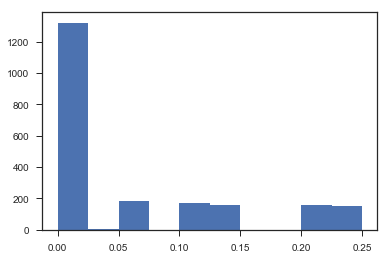

In [10]:
# an initial look at how product line items in the orders are distributed based on any discounts
plt.hist(order_detail["Discount"])
plt.show()

The vast majority of products ordered have no discount.
For ordered products that had a discount applied, the distribution into different levels of discount looks roughly equal.

The order_detail dataframe does not have any totals so I created a total for each line as that value would appear on the actual order.

In [11]:
# make a new column to calculate the line item total
order_detail['line_total'] = order_detail['Quantity'] * order_detail['UnitPrice'] * (1 - order_detail['Discount'])

order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


In [12]:
# a little more EDA, how many orders had at least one product discounted?
rs = con.execute('SELECT DISTINCT OrderId FROM OrderDetail WHERE Discount > 0')

orders_with_discount = pd.DataFrame(rs.fetchall())

orders_with_discount.columns = ['Id']

orders_with_discount.count()

2019-05-11 08:15:20,776 INFO sqlalchemy.engine.base.Engine SELECT DISTINCT OrderId FROM OrderDetail WHERE Discount > 0
2019-05-11 08:15:20,779 INFO sqlalchemy.engine.base.Engine ()


Id    380
dtype: int64

380 orders had at least one discounted product. How many orders had no discounts?

In [13]:
# make a list of orders that have no discounted items
orders_without_discount = orders.merge(orders_with_discount.drop_duplicates(), on=['Id'], how='left', indicator=True)

orders_without_discount = orders_without_discount[orders_without_discount._merge != 'both']

orders_without_discount.count()

Id                450
CustomerId        450
EmployeeId        450
OrderDate         450
RequiredDate      450
ShippedDate       440
ShipVia           450
Freight           450
ShipName          450
ShipAddress       450
ShipCity          450
ShipRegion        450
ShipPostalCode    446
ShipCountry       450
_merge            450
dtype: int64

450 orders had no discounted items. Just to check the totals, I checked the total number of orders.

In [14]:
len(orders)

830

450 orders with no discount plus 380 orders that had a discount equals 830 total orders. Now checking for any missing values in the orders table. 

In [15]:
orders.count()

Id                830
CustomerId        830
EmployeeId        830
OrderDate         830
RequiredDate      830
ShippedDate       809
ShipVia           830
Freight           830
ShipName          830
ShipAddress       830
ShipCity          830
ShipRegion        830
ShipPostalCode    811
ShipCountry       830
dtype: int64

* 19 orders have no value for ShipPostalCode.
* 21 orders have no value for ShippedDate.

To investigate the first question:

**_Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?_**

I added four new columns to the orders table:
* order_total
* unique_products_count
* all_items_total_qty_count
* discount_flag


In [16]:
# add blank columns to orders dataframe
orders['order_total'] = 0
orders['unique_products_count'] = 0
orders['all_items_total_qty_count'] = 0
orders['discount_flag'] = False #True if order contains any discounted items, otherwise False

orders.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,0,0,0,False
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,0,0,0,False
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,0,0,0,False
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,0,0,0,False
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,0,0,0,False


In [17]:
# populate the new columns

for index, row in orders.iterrows():
    order_id = row['Id']     #row['Id'] gets the OrderId column value
    order_index = index
    
# get the relevant rows from order_detail
    temp_df = order_detail.loc[order_detail['OrderId'] == order_id]
    
    #clear the variables
    order_total = 0
    order_product_ids_count = 0
    product_ids = []
    all_items_total_qty_count = 0
    discount_flag = False
    
    # iterate through the order_detail rows and calculate the values
    for index, row in temp_df.iterrows():
        order_total += round((row['UnitPrice'] * row['Quantity']) * (1 - row['Discount']),2)
        product_ids.append(row['ProductId'])  #get the unique product id's
        all_items_total_qty_count += row['Quantity'] #count up the total # of units of all products in the order

    #check if any discount, if yes skip for this row, otherwise check if the current row has a discount
        if discount_flag == False:
            if row['Discount'] > 0:
                discount_flag = True
    
    product_ids = set(product_ids)     #make a set (unique values only) of the product id's
    
# add these values to the order in the orders dataframe
    orders.iloc[order_index, orders.columns.get_loc('order_total')] = order_total
    orders.iloc[order_index, orders.columns.get_loc('unique_products_count')] = len(product_ids)
    orders.iloc[order_index, orders.columns.get_loc('all_items_total_qty_count')] = all_items_total_qty_count
    orders.iloc[order_index, orders.columns.get_loc('discount_flag')] = discount_flag


In [18]:
orders.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,440.00,3,27,False
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,1863.40,2,49,False
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,1552.60,3,60,True
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,654.06,3,41,True
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,3597.90,3,105,True


I then split the orders table into two tables, one for orders with a discount and one for orders without a discount and checked to make sure the length of the tables matched the original SQL tables.


In [19]:
discount = orders[orders['discount_flag'] == True]
len(discount)

380

In [20]:
no_discount = orders[orders['discount_flag'] == False]
len(no_discount)

450

I wanted to first look at a scatter plot comparing orders with and without a discount.

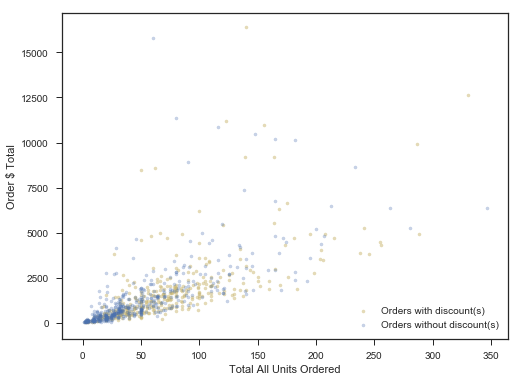

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(discount['all_items_total_qty_count'], discount['order_total'], s=10, c='y', alpha=.5, label='Orders with discount(s)')
ax.scatter(no_discount['all_items_total_qty_count'], no_discount['order_total'], s=10, c='b', alpha=.3, label='Orders without discount(s)')
ax.set_xlabel("Total All Units Ordered")
ax.set_ylabel("Order $ Total")
plt.legend(loc='lower right')

There does appear to be a correlation where orders wtih a discount tend to have a higher total units ordered. To investigate further, I need to look at the level of discount present. To do this I will need to look at the order_details table.

I could take each product in of the order_detail table and calculate the average units ordered per each level of discount. Much harder would be to do this for each individual product.

In [22]:
order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


Assign each product line item to one of four discount groups:
* 1 = discount less than 5% or no discount
* 2 = discount equal to or greater than 5% but less than 10%
* 3 = discount equal to or greater than 10% but less than 20%
* 4 = discount equal to or greater than 20%

In [23]:
#create the new column and fill it with zero's
order_detail['discount_group'] = 0

#iterate through the dataframe and assign each line to the correct group
for index, row in order_detail.iterrows():
#     x = order_detail.columns.get_loc('discount_group')
#     print(x)
#     break
    if row['Discount'] < 0.05:
        order_detail.iloc[index, 7] = 1
    if row['Discount'] >= 0.05 and row['Discount'] < 0.10:
        order_detail.iloc[index, 7] = 2
    if row['Discount'] >= .1 and row['Discount'] < 0.2:
        order_detail.iloc[index, 7] = 3
    if row['Discount'] >= 0.2:
        order_detail.iloc[index, 7] = 4


In [24]:
order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total,discount_group
0,10248/11,10248,11,14.0,12,0.0,168.0,1
1,10248/42,10248,42,9.8,10,0.0,98.0,1
2,10248/72,10248,72,34.8,5,0.0,174.0,1
3,10249/14,10249,14,18.6,9,0.0,167.4,1
4,10249/51,10249,51,42.4,40,0.0,1696.0,1


In [25]:
grouped = order_detail.groupby('discount_group')
print (grouped['Quantity'].agg(np.mean))


discount_group
1    21.609517
2    27.870968
3    26.733333
4    27.619048
Name: Quantity, dtype: float64


Orders with a discount have a significantly higher mean quantity ordered than orders with a discount less than 5%


In [26]:
print(grouped['line_total'].agg(np.mean))

discount_group
1    567.210544
2    793.985454
3    542.440342
4    597.205306
Name: line_total, dtype: float64


Orders with a discounts in category 2 and 4 have higher mean quantity ordered than orders in groups 1 and 3.

Make a scatter chart to further explore these relationships.


In [27]:
order_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 8 columns):
Id                2155 non-null object
OrderId           2155 non-null int64
ProductId         2155 non-null int64
UnitPrice         2155 non-null float64
Quantity          2155 non-null int64
Discount          2155 non-null float64
line_total        2155 non-null float64
discount_group    2155 non-null int64
dtypes: float64(3), int64(4), object(1)
memory usage: 134.8+ KB


In [28]:
order_detail['discount_group'] = pd.Categorical(order_detail['discount_group'])
print (order_detail.dtypes)

Id                  object
OrderId              int64
ProductId            int64
UnitPrice          float64
Quantity             int64
Discount           float64
line_total         float64
discount_group    category
dtype: object


In [44]:
temp = [('1',21.609517),('2',27.870968),('3',26.733333),('4',27.619048)]
temp_df = pd.DataFrame(temp, columns=['discount_group', 'mean_quantity'])
temp_df.head()

,discount_group,mean_quantity
0,1,21.609517
1,2,27.870968
2,3,26.733333
3,4,27.619048


<BarContainer object of 4 artists>

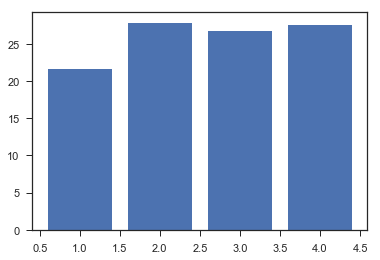

In [53]:
plt.bar(x='discount_group', height='mean_quantity', data=temp_df, align='center')

The average quantity ordered appears to be similarly higher for each category of discount, as compared to products with a less than 5% discount.

<BarContainer object of 4 artists>

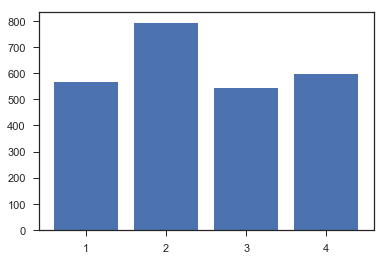

In [84]:
# bar chart of line_total by discount_category
temp = [('1',567.210544),('2',793.985454),('3',542.440342),('4',597.205306)]
temp_df = pd.DataFrame(temp, columns=['discount_group', 'line_total'])
# temp_df.head()
plt.bar(x='discount_group', height='line_total', data=temp_df, align='center')

It looks like products ordered with a discount_category of 2 generate the largest mean dollar amount.

Discount category 2 = discounts of at least 5% but less than 10%.

In [80]:
# make a temp dataframe of only the rows with a discount of 5% or more
temp_df = order_detail[order_detail['discount_group'] != 1]
temp_df.head()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total,discount_group
6,10250/51,10250,51,42.4,35,0.15,1261.40,3
7,10250/65,10250,65,16.8,15,0.15,214.20,3
8,10251/22,10251,22,16.8,6,0.05,95.76,2
9,10251/57,10251,57,15.6,15,0.05,222.30,2
11,10252/20,10252,20,64.8,40,0.05,2462.40,2


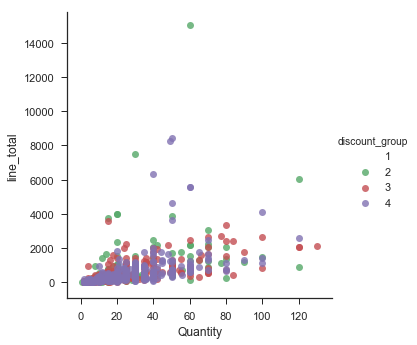

In [81]:
sns.lmplot('Quantity', 'line_total', data=temp_df, hue='discount_group', fit_reg=False)

In [73]:
order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total,discount_group
0,10248/11,10248,11,14.0,12,0.0,168.0,1
1,10248/42,10248,42,9.8,10,0.0,98.0,1
2,10248/72,10248,72,34.8,5,0.0,174.0,1
3,10249/14,10249,14,18.6,9,0.0,167.4,1
4,10249/51,10249,51,42.4,40,0.0,1696.0,1


Hypothesis test #1:

Ho: There is no difference in the mean quantity ordered of products with a discount of 5% or more as compared to with a discount of less than 5%.

Ha: The mean quantity of products ordered with a discount of 5% or more is higher than products ordered with a discount of less than 5%.

In [57]:
mean_with_discount = np.mean(order_detail[order_detail['Discount'] >= 0.05]['Quantity'])
mean_with_discount

27.323706377858002

In [64]:
# get the number of rows that have a discount of 5% or greater
len(order_detail[order_detail['Discount'] >= 0.05])


831

In [59]:
mean_without_discount = np.mean(order_detail[order_detail['Discount'] < 0.05]['Quantity'])
mean_without_discount

21.6095166163142

In [65]:
# get the numer of rows that have a discount less than 0.05
len(order_detail[order_detail['Discount'] < 0.05])

1324

In [63]:
len(order_detail)

2155

In [71]:
actual_difference = mean_with_discount - mean_without_discount
actual_difference

5.714189761543803

In [67]:
def permutation_samples(key_value_list, no_of_trials, sample_size, column):
    difference_of_means = []

    while len(difference_of_means) < no_of_trials:
        temp_keys = key_value_list.index.values
        treatment_keys = np.random.choice(temp_keys, sample_size, replace=False)

        treatment = key_value_list[key_value_list.index.isin(treatment_keys)]
        control = key_value_list[~key_value_list.index.isin(treatment_keys)]

        # actual difference, positive or negative
        difference = np.mean(treatment[column]) -  np.mean(control[column])
        difference_of_means.append(difference)

#         print('difference value added:', abs_difference)
    return(difference_of_means)

/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


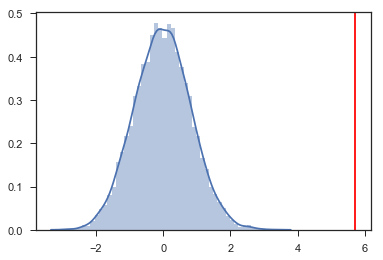

In [70]:
permutation_list = permutation_samples(order_detail, 10000, 831, 'Quantity')

sns.distplot(permutation_list)
plt.axvline(actual_difference, color='red')

Clearly the observed mean difference of the quantity ordered between products with a discount and without a discount is extremely unlikely to be from chance. 

/Users/giovanni/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


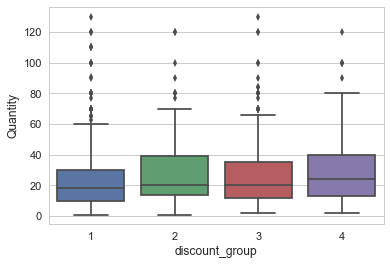

In [97]:
# look at bar charts of discount levels
sns.set_style("whitegrid") 
  
sns.boxplot(x = 'discount_group', y = 'Quantity', data = order_detail)


/Users/giovanni/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


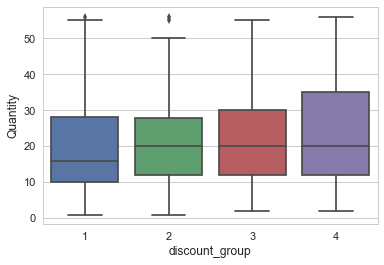

In [96]:
#there are many outliers in all discount_groups. I chose to eliminate all outliers at the top 5% of values.
quantile = order_detail['Quantity'].quantile(0.95)
temp_df = order_detail[order_detail['Quantity'] < quantile]
sns.boxplot(x = 'discount_group', y = 'Quantity', data = temp_df)

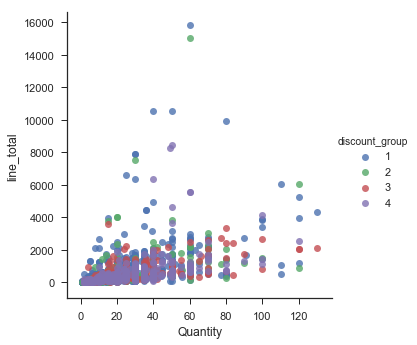

In [87]:
# fig, ax = plt.subplots(figsize=(8, 6))
sns.lmplot( x='Quantity', y='line_total', data=order_detail, fit_reg=False, hue='discount_group', legend=True)
 
# Move the legend to an empty part of the plot
# plt.legend(loc='lower right')
 
#sns.plt.show()


To investigate the second question:

**_Do older customers make larger orders?_**

I added five new columns to the customers table:
    * total number of orders
    * total $ value of all orders
    * first order date
    * last order date
    * average orders/month (year?, etc.)


In [98]:
# add columns to customer dataframe: orders_count, orders_value, first_order_date, last_order_date
customers['orders_count'] = 0
customers['orders_value'] = 0
customers['first_order_date'] = 0
customers['last_order_date'] = 0

# cast date columns as pandas datetime
customers['first_order_date'] = pd.to_datetime(customers['first_order_date'])
customers['last_order_date'] = pd.to_datetime(customers['last_order_date'])

customers.head()


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,0,0,1970-01-01,1970-01-01
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745,0,0,1970-01-01,1970-01-01
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None,0,0,1970-01-01,1970-01-01
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750,0,0,1970-01-01,1970-01-01
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67,0,0,1970-01-01,1970-01-01


In [99]:
#get orders count
orders_count = orders.groupby("CustomerId")["Id"].nunique()
orders_count.head(10)

CustomerId
ALFKI     6
ANATR     4
ANTON     7
AROUT    13
BERGS    18
BLAUS     7
BLONP    11
BOLID     3
BONAP    17
BOTTM    14
Name: Id, dtype: int64

In [100]:
orders_count = orders_count.reset_index()
# orders_count.describe()
orders_count.head(10)

,CustomerId,Id
0,ALFKI,6
1,ANATR,4
2,ANTON,7
3,AROUT,13
4,BERGS,18
5,BLAUS,7
6,BLONP,11
7,BOLID,3
8,BONAP,17
9,BOTTM,14


In [101]:
orders_count.rename(columns={'Id':'order_count'}, inplace=True)
orders_count.head()

,CustomerId,order_count
0,ALFKI,6
1,ANATR,4
2,ANTON,7
3,AROUT,13
4,BERGS,18


In [102]:
orders_count.describe()

,order_count
count,89.000000
mean,9.325843
std,5.810991
min,1.000000
25%,5.000000
50%,8.000000
75%,12.000000
max,31.000000


/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Distribution of the Number of Orders per Customer')

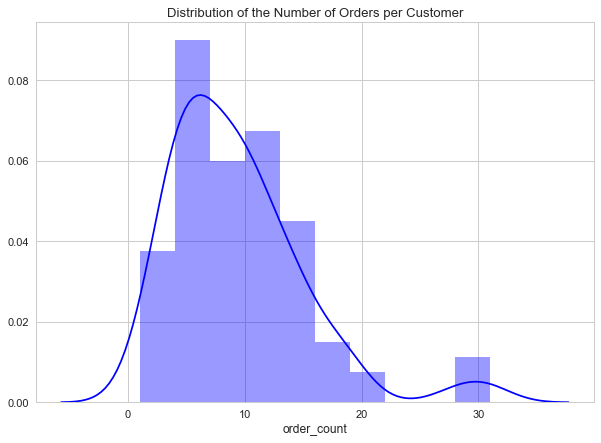

In [103]:
plt.figure(figsize=(10,7))

sns.distplot(orders_count['order_count'], color="blue",)
plt.title("Distribution of the Number of Orders per Customer")

In [104]:
# add order count to each customer record

for index, row in orders_count.iterrows():
    customer_id = row['CustomerId']
    order_count = row['order_count']
    customer_index = "NONE"
    
    # all customer id's in the customer table had five digits
    # this if/else statement was used to identify orders where the customer id was not five digits long
    if len(customer_id) == 5:                               
        customer_index = customers.loc[customers['Id'] == customer_id].index
        customers.iloc[customer_index, customers.columns.get_loc('orders_count')] = order_count
    else:
        print('CustomerId: {}'.format(customer_id))
        print('Order Count: {}'.format(order_count))
        print('Customer Index: {}'.format(customer_index))

In [105]:
#calculate customers total value of all orders
orders_total = orders.groupby("CustomerId")['order_total'].agg(sum)

orders_total = orders_total.reset_index()
orders_total.head()

,CustomerId,order_total
0,ALFKI,4273.00
1,ANATR,1402.95
2,ANTON,7023.98
3,AROUT,13390.65
4,BERGS,24927.58


In [106]:
# add the total value of all orders to each customer
for index, row in orders_total.iterrows():
    customer_id = row['CustomerId']
    order_total = row['order_total']
    customer_index = customers.loc[customers['Id'] == customer_id].index
    customers.iloc[customer_index,customers.columns.get_loc('orders_value')] = order_total

In [107]:
customers.head(10)

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,6,4273.00,1970-01-01,1970-01-01
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745,4,1402.95,1970-01-01,1970-01-01
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None,7,7023.98,1970-01-01,1970-01-01
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750,13,13390.65,1970-01-01,1970-01-01
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67,18,24927.58,1970-01-01,1970-01-01
5,BLAUS,Blauer See Delikatessen,Hanna Moos,Sales Representative,Forsterstr. 57,Mannheim,Western Europe,68306,Germany,0621-08460,0621-08924,7,3239.80,1970-01-01,1970-01-01
6,BLONP,Blondesddsl père et fils,Frédérique Citeaux,Marketing Manager,"24, place Kléber",Strasbourg,Western Europe,67000,France,88.60.15.31,88.60.15.32,11,18534.08,1970-01-01,1970-01-01
7,BOLID,Bólido Comidas preparadas,Martín Sommer,Owner,"C/ Araquil, 67",Madrid,Southern Europe,28023,Spain,(91) 555 22 82,(91) 555 91 99,3,4232.85,1970-01-01,1970-01-01
8,BONAP,Bon app,Laurence Lebihan,Owner,"12, rue des Bouchers",Marseille,Western Europe,13008,France,91.24.45.40,91.24.45.41,17,21963.24,1970-01-01,1970-01-01
9,BOTTM,Bottom-Dollar Markets,Elizabeth Lincoln,Accounting Manager,23 Tsawassen Blvd.,Tsawassen,North America,T2F 8M4,Canada,(604) 555-4729,(604) 555-3745,14,20801.59,1970-01-01,1970-01-01


In [108]:
customers.describe()

,orders_count,orders_value
count,91.000000,91.000000
mean,9.120879,13909.813297
std,5.908253,20103.531743
min,0.000000,0.000000
25%,5.000000,3166.755000
50%,8.000000,7023.980000
75%,12.000000,16646.830000
max,31.000000,110277.320000


In [109]:
# inspect the count of orders for customers

order_counts = customers.groupby('orders_count')['orders_count'].count()
order_counts

orders_count
0      2
1      1
2      2
3      7
4      6
5     10
6      8
7      7
8      4
9      5
10    11
11     4
12     3
13     3
14     6
15     3
17     1
18     3
19     2
28     1
30     1
31     1
Name: orders_count, dtype: int64

Two customers have no order, one customer has only one order.

In [110]:
under_two_orders = customers.loc[customers['orders_count'] < 2]
print (under_two_orders)

       Id                           CompanyName      ContactName  \
12  CENTC            Centro comercial Moctezuma  Francisco Chang   
21  FISSA  FISSA Fabrica Inter. Salchichas S.A.       Diego Roel   
56  PARIS                     Paris spécialités   Marie Bertrand   

          ContactTitle                  Address         City           Region  \
12   Marketing Manager  Sierras de Granada 9993  México D.F.  Central America   
21  Accounting Manager       C/ Moralzarzal, 86       Madrid  Southern Europe   
56               Owner  265, boulevard Charonne        Paris   Western Europe   

   PostalCode Country            Phone              Fax  orders_count  \
12      05022  Mexico     (5) 555-3392     (5) 555-7293             1   
21      28034   Spain   (91) 555 94 44   (91) 555 55 93             0   
56      75012  France  (1) 42.34.22.66  (1) 42.34.22.77             0   

    orders_value first_order_date last_order_date  
12         100.8       1970-01-01      1970-01-01  
21   